In [50]:
from crear_dataset import *
from funcions_net import *
import numpy as np
import matplotlib.pyplot as plt
import pyreadstat
import pandas as pd
from preprocessing import *
from func_sel import *
import pyreadstat
import pandas as pd
from crear_dataset import *


In [51]:

df_orig, meta = pyreadstat.read_sav("CEJFEAjut2015Updated.sav")

df_variables = pd.read_csv("variables.csv", sep=';')

dict = create_dict(meta)

print("Creem diccionari")

Creem diccionari


In [52]:

df = create_dataset_2(df_orig, dict)
df = origen(df,df_orig)

Hola


c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\crear_dataset.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Delictes molt violents'] = 0
c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\crear_dataset.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final[dict[num]] = np.where(df[dict[num]] == 5, 1, 0)
c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\crear_dataset.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [53]:
print("Mirem quants nans tenim a cada columna")
netejat,df = neteja_na_columns(df, llindar=0.6)

df = omple_nans(df)

print("Columnes netejades")
## fem label encoding de les columnes categòriques
df = label_encoding(df)

df['temps_fins_reincidencia1a'] = df['temps_fins_reincidencia1a'].apply(lambda x: 1095 if x > 1095 else x)

Mirem quants nans tenim a cada columna
Columnes netejades


c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\preprocessing.py:73: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_net[col].fillna(mitjana, inplace=True)
c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\preprocessing.py:79: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For ex

In [54]:
num_columnes = df.shape[1]
print("Hem netejat les columnes i hem fet label encoding")
print("Tenim ", num_columnes, " columnes")

Hem netejat les columnes i hem fet label encoding
Tenim  89  columnes


In [55]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='temps_fins_reincidencia1a'), df['temps_fins_reincidencia1a'], test_size=0.2,random_state=42)


In [56]:
from sklearn.preprocessing import StandardScaler

## normalitzem les dades
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)



In [57]:
from ctgan import CTGAN
from sklearn.preprocessing import MinMaxScaler


# Suposem un dataset real en 'df'
# Suposant que X_train és un DataFrame i y_train és una sèrie
X_train_2 = pd.DataFrame(X_train, columns=df.drop(columns='temps_fins_reincidencia1a').columns).reset_index(drop=True)
y_train_2 = pd.Series(y_train).reset_index(drop=True)

scaler_ytrain = MinMaxScaler()
y_train_2_t = scaler_ytrain.fit_transform(y_train_2.values.reshape(-1, 1))


df_train = X_train_2.copy()
df_train['temps_fins_reincidencia1a'] = y_train_2_t


In [58]:
from sklearn.utils import resample

n_samples = int(len(df_train) * 1)
df_train_bootstrap = resample(df_train, replace=True, n_samples=n_samples, random_state=42)

# Afegim soroll discret:
# df_train_bootstrap_noisy = afegir_soroll_discret(df_train_bootstrap, prob_mutacio=0.1)


In [59]:
from ctgan import CTGAN

# Suposem un dataset real en 'df'
# Suposant que X_train és un DataFrame i y_train és una sèrie



print("Entrenem el model")
model = CTGAN(
    epochs=50,
    batch_size=20,
    generator_dim=(128, 128),  
    discriminator_dim=(64, 64),  
    embedding_dim=256,  
    generator_lr=5e-4,  # Reduïm una mica la taxa d'aprenentatge del generador
    discriminator_lr=1e-4,  # Discriminador aprèn més lent
    pac=1,
    verbose=True
)

model.fit(df_train_bootstrap)  # Entrenar amb les dades originals



Entrenem el model


Gen. (-0.42) | Discrim. (0.35): 100%|██████████| 50/50 [00:09<00:00,  5.49it/s]


In [60]:
synthetic_data = model.sample(20)  # Generar 1000 registres sintètics

X_synthetic = synthetic_data.drop(columns='temps_fins_reincidencia1a')
y_synthetic = synthetic_data['temps_fins_reincidencia1a']

In [61]:
y_synthetic_reconvertit = scaler_ytrain.inverse_transform(y_synthetic.values.reshape(-1, 1))

y_synthetic_reconvertit = pd.Series(y_synthetic_reconvertit.flatten())

print(y_synthetic_reconvertit)


0      997.167331
1     1682.128290
2     2112.184604
3      865.137717
4      974.952356
5     1006.448492
6     1009.177076
7      998.982480
8      990.707348
9      978.333046
10    1002.692783
11     992.666227
12     952.745932
13    1009.516716
14    1002.036032
15     990.969849
16    1004.578907
17    1009.825448
18    1008.833311
19    1020.631692
dtype: float64


In [62]:
import pandas as pd

# Assegura que y_train_2 és una Series
X_synthetic = pd.concat([X_train_2, X_synthetic], ignore_index=True)
y_synthetic = pd.concat([y_train_2, y_synthetic_reconvertit], ignore_index=True)


In [63]:
X_train_filtrat, coef_significatius = filter_significant_features(X_synthetic,y_synthetic, df, llindar=0.1,alpha=1, print_results=True)

Hem fet el model Lasso
Hem trobat  19  coeficients nuls
Hem trobat  69  coeficients no nuls
Els coeficients no nuls ordenats per valor absolut són:
SAVRYTot                 -292.524713
ICUJ_PT                  -249.991213
CAPEe_PT_3items          -198.221842
TriPMTotal               -186.249469
SAVRYSoc                  181.610989
TRFTGrupExtCAPEe          176.794160
ICUJ_UE                   161.807127
EdatAD                    152.049403
YPI_LY                    151.383482
TRFMGrupDSMCDConsCAPEe   -132.413197
PCLj_PT                  -127.384599
YPI_CU                    114.075962
VASTVic                   113.969735
CAPEe_PT                   96.621035
ICUJ_UC                    96.232227
SD3Narc                   -93.671143
TriPMMean                  93.269469
CCA_PT                     91.697446
PCLYVMPT                   91.321396
VASTDir                   -90.244660
dtype: float64


c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.036e+05, tolerance: 1.759e+03
  model = cd_fast.enet_coordinate_descent(


In [64]:
print("Les columnes més significatives són: ")
print(df.columns[coef_significatius.argsort()[::-1][0:20]])

Les columnes més significatives són: 
Index(['SD3Psyc', 'YPI_IR', 'TriPMTotal', 'EdatAD', 'ICUJ_UC', 'YPI_UN',
       'YSRTotProb', 'PCLj_PT', 'TriPMDisi', 'SAVRYInd', 'ICUJ_CA', 'PCLx_PT',
       'Niv_Esc', 'SD3Mach', 'YPI_PT', 'TriPMMean', 'CAPEo_PT',
       'TRFMGrupDSMCDConsCAPEe', 'VASTVic', 'SAVRYTot'],
      dtype='object')


In [65]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

## fem grid search per trobar els millors hiperparàmetres

param_grid = {
    'n_estimators': [200,500,1000],
    'max_depth': [30,50,75],
}

rf = RandomForestRegressor()

grid_search = GridSearchCV(
    rf, 
    param_grid, 
    cv=10, 
    scoring='neg_mean_squared_error', 
    return_train_score=True
)

# Realitzem el Grid Search
grid_search.fit(X_train_filtrat, y_synthetic)

# Resultats
print("Millor paràmetre:", grid_search.best_params_)
print("Millor precisió:", -grid_search.best_score_)  # Negatiu perquè s'ha usat neg_mean_squared_error

# Mostrem la mitjana dels resultats de test
print("Mitjana dels resultats de test per cada combinació:")
print(np.mean(grid_search.cv_results_['mean_test_score'] * -1))  # Multipliquem per -1 per obtenir el MSE positiu

best_model = grid_search.best_estimator_


Millor paràmetre: {'max_depth': 30, 'n_estimators': 200}
Millor precisió: 83591.11110422094
Mitjana dels resultats de test per cada combinació:
85388.14618675015


In [66]:
# Obtenim la importància de cada característica
coef_importants = best_model.feature_importances_

# Obtenim els noms de les característiques (suposant que tenim un DataFrame 'df')
feature_names = X_train_filtrat.columns  

# Ordenem les característiques segons la seva importància (de major a menor)
indices_ordenats = coef_importants.argsort()[::-1][0:20]

# Mostrem els noms de les 20 característiques més importants amb la seva importància
print("Les 20 característiques més importants són:")
for i in indices_ordenats:
    print(f"{feature_names[i]}: {coef_importants[i]:.4f}")



Les 20 característiques més importants són:
t_internamentCape: 0.2265
Total_Del: 0.1816
CAPEe_PT: 0.1219
YSRTotProb: 0.1104
SAVRYTot: 0.0787
YPI_CU: 0.0363
SAVRYInd: 0.0258
EdatAD: 0.0147
YPI_LY: 0.0129
Llatins: 0.0122
SD3Mach: 0.0104
TriPMMean: 0.0101
Fet10_tipologia_JA: 0.0101
TriPMDisi: 0.0099
CAPEe_PT_3items: 0.0097
YPI_GM: 0.0095
ICUJ_UE: 0.0091
Nord_America: 0.0075
NSancMGreu: 0.0072
CCA_PT: 0.0066



--- AVALUACIÓ FINAL EN TEST ---
MSE (Test): 45229.4342


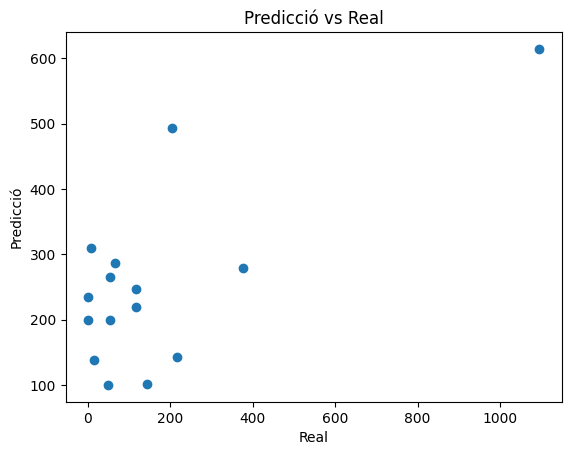

In [67]:
from sklearn.metrics import mean_squared_error, r2_score

X_test = scaler.transform(X_test)
X_test_filtrat = pd.DataFrame(X_test, columns=df.drop(columns='temps_fins_reincidencia1a').columns)[coef_significatius.index]


y_test_pred = best_model.predict(X_test_filtrat)

# Calculem la mètrica MSE i R²
test_mse = mean_squared_error(y_test, y_test_pred)

print("\n--- AVALUACIÓ FINAL EN TEST ---")
print(f"MSE (Test): {test_mse:.4f}")


## plot de les prediccions
plt.scatter(y_test, y_test_pred)
plt.xlabel('Real')
plt.ylabel('Predicció')
plt.title('Predicció vs Real')
plt.show()

In [68]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

# Definim la graella d'hiperparàmetres
param_grid = {
    'n_estimators': [20, 50, 100],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2]
}

xgb = XGBRegressor(objective='reg:squarederror')

grid_search = GridSearchCV(
    xgb, 
    param_grid, 
    cv=10, 
    scoring='neg_mean_squared_error', 
    return_train_score=True
)

# Realitzem el Grid Search
grid_search.fit(X_train_filtrat, y_train)

# Resultats
print("Millor paràmetre:", grid_search.best_params_)
print("Millor precisió:", -grid_search.best_score_)  # Negatiu perquè s'ha usat neg_mean_squared_error

#


ValueError: Found input variables with inconsistent numbers of samples: [77, 57]